In [ ]:
import numpy as np
import torch
import gymnasium as gym
import random

from scripts.sac import *
from scripts.action_embedding_net import *
from scripts.save_everything import *
from scripts.load_everything import *
from scripts.generate_everything import *


# Make environment deterministic for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create the environment
env_name = "HalfCheetah-v4"
env = gym.make(env_name)
env.action_space.seed(42)
env.reset(seed=42)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

Using device: cpu


/Users/williams/anaconda3/envs/rl/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/Users/williams/anaconda3/envs/rl/lib/python3.8/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(


# record the training models

/Users/williams/anaconda3/envs/rl/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/Users/williams/anaconda3/envs/rl/lib/python3.8/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/williams/anaconda3/envs/rl/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 10, Avg. Reward: -258.50
Saved episode 10 model
Episode: 20, Avg. Reward: -175.37
Saved episode 20 model
Episode: 30, Avg. Reward: 195.22
Saved episode 30 model
Episode: 40, Avg. Reward: 1214.75
Saved episode 40 model
Episode: 50, Avg. Reward: 1835.34
Saved episode 50 model
Episode: 60, Avg. Reward: 2491.19
Saved episode 60 model
Episode: 70, Avg. Reward: 2960.35
Saved episode 70 model
Episode: 80, Avg. Reward: 3337.11
Saved episode 80 model
Episode: 90, Avg. Reward: 3697.56
Saved episode 90 model
Episode: 100, Avg. Reward: 3775.69
Saved episode 100 model


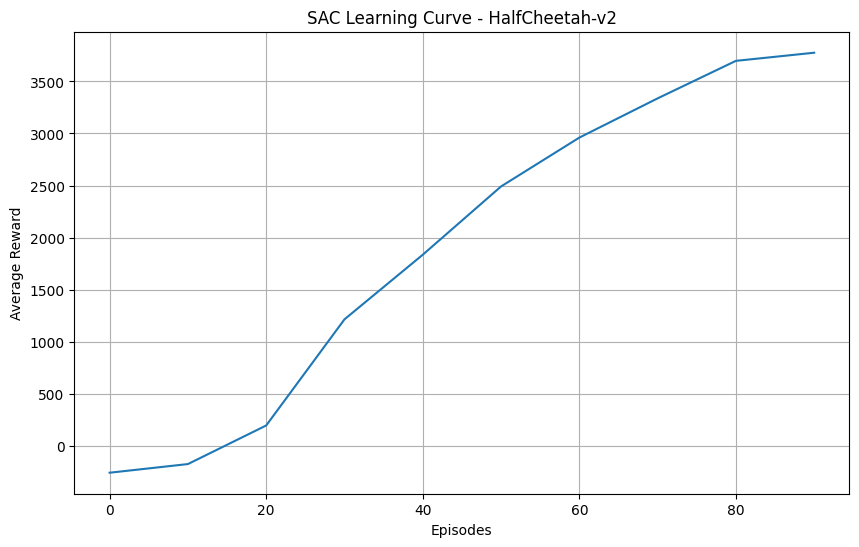

In [2]:

agent = SAC(
    state_dim=state_dim,
    action_dim=action_dim,
    action_space=env.action_space,
    lr=3e-4,
    hidden_dim=256,
    buffer_size=1000000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    alpha=0.2,
    auto_entropy_tuning=True
    )
# save the initial model
agent.save('./tracking', f"episode_0.pth")

# Training parameters
num_episodes = 100
max_steps = 1000
eval_interval = 10
    
# Train the agent
episode_rewards, avg_rewards = train_record(env_name, agent, num_episodes, max_steps, eval_interval, record_interval=10)


# load the embedding model

In [2]:
state_action_model, action_model = load_embedding_models(state_dim, action_dim)

Loaded embedding models from ./models


# generate dataset for all inter-models

In [4]:
# load every model in dir tracking and for each model generate 10 trajectories
for filename in os.listdir("tracking"):
    if filename.endswith('.pth'):
        agent = SAC(
            state_dim=state_dim,
            action_dim=action_dim,
            action_space=env.action_space,
            lr=3e-4,
            hidden_dim=256,
            buffer_size=1000000,
            batch_size=256,
            tau=0.005,
            gamma=0.99,
            alpha=0.2,
            auto_entropy_tuning=True
        )
        agent = load_agent(env, os.path.join("tracking", filename))
        print(f"Loaded model: {filename}")
        
        # Generate trajectories
        trajectories, offline_dataset = generate_expert_trajectories(env, agent, num_trajectories=10, max_steps=1000)
        print(f"Generated trajectories for model: {filename}")
        sa_embeddings, a_embeddings = generate_all_embeddings(offline_dataset, state_action_model, action_model)
        print(f"Generated embeddings for model: {filename}")
        # Save the embeddings
        save_embeddings(sa_embeddings, a_embeddings, directory="tracking_embeddings", prefix=filename[:-4])
        print(f"Saved embeddings for model: {filename}")


Loaded trained SAC agent
Loaded model: episode_30.pth


Generating expert trajectories:   0%|          | 0/10 [00:00<?, ?it/s]

Trajectory 1: 1000 steps
Trajectory 2: 1000 steps
Trajectory 3: 1000 steps
Trajectory 4: 1000 steps
Trajectory 5: 1000 steps
Trajectory 6: 1000 steps
Trajectory 7: 1000 steps
Trajectory 8: 1000 steps
Trajectory 9: 1000 steps
Trajectory 10: 1000 steps
Generated trajectories for model: episode_30.pth
Generated embeddings for model: episode_30.pth
Saved embeddings to tracking_embeddings
Saved embeddings for model: episode_30.pth
Loaded trained SAC agent
Loaded model: episode_100.pth


Generating expert trajectories:   0%|          | 0/10 [00:00<?, ?it/s]

Trajectory 1: 1000 steps
Trajectory 2: 1000 steps
Trajectory 3: 1000 steps
Trajectory 4: 1000 steps
Trajectory 5: 1000 steps
Trajectory 6: 1000 steps
Trajectory 7: 1000 steps
Trajectory 8: 1000 steps
Trajectory 9: 1000 steps
Trajectory 10: 1000 steps
Generated trajectories for model: episode_100.pth
Generated embeddings for model: episode_100.pth
Saved embeddings to tracking_embeddings
Saved embeddings for model: episode_100.pth
Loaded trained SAC agent
Loaded model: episode_20.pth


Generating expert trajectories:   0%|          | 0/10 [00:00<?, ?it/s]

Trajectory 1: 1000 steps
Trajectory 2: 1000 steps
Trajectory 3: 1000 steps
Trajectory 4: 1000 steps
Trajectory 5: 1000 steps
Trajectory 6: 1000 steps
Trajectory 7: 1000 steps
Trajectory 8: 1000 steps
Trajectory 9: 1000 steps
Trajectory 10: 1000 steps
Generated trajectories for model: episode_20.pth
Generated embeddings for model: episode_20.pth
Saved embeddings to tracking_embeddings
Saved embeddings for model: episode_20.pth
Loaded trained SAC agent
Loaded model: episode_90.pth


Generating expert trajectories:   0%|          | 0/10 [00:00<?, ?it/s]

Trajectory 1: 1000 steps
Trajectory 2: 1000 steps
Trajectory 3: 1000 steps
Trajectory 4: 1000 steps
Trajectory 5: 1000 steps
Trajectory 6: 1000 steps
Trajectory 7: 1000 steps
Trajectory 8: 1000 steps
Trajectory 9: 1000 steps
Trajectory 10: 1000 steps
Generated trajectories for model: episode_90.pth
Generated embeddings for model: episode_90.pth
Saved embeddings to tracking_embeddings
Saved embeddings for model: episode_90.pth
Loaded trained SAC agent
Loaded model: episode_50.pth


Generating expert trajectories:   0%|          | 0/10 [00:00<?, ?it/s]

Trajectory 1: 1000 steps
Trajectory 2: 1000 steps
Trajectory 3: 1000 steps
Trajectory 4: 1000 steps
Trajectory 5: 1000 steps
Trajectory 6: 1000 steps
Trajectory 7: 1000 steps
Trajectory 8: 1000 steps
Trajectory 9: 1000 steps
Trajectory 10: 1000 steps
Generated trajectories for model: episode_50.pth
Generated embeddings for model: episode_50.pth
Saved embeddings to tracking_embeddings
Saved embeddings for model: episode_50.pth
Loaded trained SAC agent
Loaded model: episode_40.pth


Generating expert trajectories:   0%|          | 0/10 [00:00<?, ?it/s]

Trajectory 1: 1000 steps
Trajectory 2: 1000 steps
Trajectory 3: 1000 steps
Trajectory 4: 1000 steps
Trajectory 5: 1000 steps
Trajectory 6: 1000 steps
Trajectory 7: 1000 steps
Trajectory 8: 1000 steps
Trajectory 9: 1000 steps
Trajectory 10: 1000 steps
Generated trajectories for model: episode_40.pth
Generated embeddings for model: episode_40.pth
Saved embeddings to tracking_embeddings
Saved embeddings for model: episode_40.pth
Loaded trained SAC agent
Loaded model: episode_80.pth


Generating expert trajectories:   0%|          | 0/10 [00:00<?, ?it/s]

Trajectory 1: 1000 steps
Trajectory 2: 1000 steps
Trajectory 3: 1000 steps
Trajectory 4: 1000 steps
Trajectory 5: 1000 steps
Trajectory 6: 1000 steps
Trajectory 7: 1000 steps
Trajectory 8: 1000 steps
Trajectory 9: 1000 steps
Trajectory 10: 1000 steps
Generated trajectories for model: episode_80.pth
Generated embeddings for model: episode_80.pth
Saved embeddings to tracking_embeddings
Saved embeddings for model: episode_80.pth
Loaded trained SAC agent
Loaded model: episode_70.pth


Generating expert trajectories:   0%|          | 0/10 [00:00<?, ?it/s]

Trajectory 1: 1000 steps
Trajectory 2: 1000 steps
Trajectory 3: 1000 steps
Trajectory 4: 1000 steps
Trajectory 5: 1000 steps
Trajectory 6: 1000 steps
Trajectory 7: 1000 steps
Trajectory 8: 1000 steps
Trajectory 9: 1000 steps
Trajectory 10: 1000 steps
Generated trajectories for model: episode_70.pth
Generated embeddings for model: episode_70.pth
Saved embeddings to tracking_embeddings
Saved embeddings for model: episode_70.pth
Loaded trained SAC agent
Loaded model: episode_60.pth


Generating expert trajectories:   0%|          | 0/10 [00:00<?, ?it/s]

Trajectory 1: 1000 steps
Trajectory 2: 1000 steps
Trajectory 3: 1000 steps
Trajectory 4: 1000 steps
Trajectory 5: 1000 steps
Trajectory 6: 1000 steps
Trajectory 7: 1000 steps
Trajectory 8: 1000 steps
Trajectory 9: 1000 steps
Trajectory 10: 1000 steps
Generated trajectories for model: episode_60.pth
Generated embeddings for model: episode_60.pth
Saved embeddings to tracking_embeddings
Saved embeddings for model: episode_60.pth
Loaded trained SAC agent
Loaded model: episode_0.pth


Generating expert trajectories:   0%|          | 0/10 [00:00<?, ?it/s]

Trajectory 1: 1000 steps
Trajectory 2: 1000 steps
Trajectory 3: 1000 steps
Trajectory 4: 1000 steps
Trajectory 5: 1000 steps
Trajectory 6: 1000 steps
Trajectory 7: 1000 steps
Trajectory 8: 1000 steps
Trajectory 9: 1000 steps
Trajectory 10: 1000 steps
Generated trajectories for model: episode_0.pth
Generated embeddings for model: episode_0.pth
Saved embeddings to tracking_embeddings
Saved embeddings for model: episode_0.pth
Loaded trained SAC agent
Loaded model: episode_10.pth


Generating expert trajectories:   0%|          | 0/10 [00:00<?, ?it/s]

Trajectory 1: 1000 steps
Trajectory 2: 1000 steps
Trajectory 3: 1000 steps
Trajectory 4: 1000 steps
Trajectory 5: 1000 steps
Trajectory 6: 1000 steps
Trajectory 7: 1000 steps
Trajectory 8: 1000 steps
Trajectory 9: 1000 steps
Trajectory 10: 1000 steps
Generated trajectories for model: episode_10.pth
Generated embeddings for model: episode_10.pth
Saved embeddings to tracking_embeddings
Saved embeddings for model: episode_10.pth


# evolution of the embedding

In [3]:
sa_list, a_list = {}, {}

# make the embedding evolution plot
for filename in os.listdir("tracking"):
    if filename.endswith('.pth'):
        sa_embeddings = np.load(os.path.join("tracking_embeddings", filename.replace('.pth', 'state_action_embeddings.npy')))
        a_embeddings = np.load(os.path.join("tracking_embeddings", filename.replace('.pth', 'action_embeddings.npy')))
        sa_list[int(filename[8:-4])//10] = sa_embeddings
        a_list[int(filename[8:-4])//10] = a_embeddings
        print(f"Loaded embeddings for model: {filename}")

Loaded embeddings for model: episode_30.pth
Loaded embeddings for model: episode_100.pth
Loaded embeddings for model: episode_20.pth
Loaded embeddings for model: episode_90.pth
Loaded embeddings for model: episode_50.pth
Loaded embeddings for model: episode_40.pth
Loaded embeddings for model: episode_80.pth
Loaded embeddings for model: episode_70.pth
Loaded embeddings for model: episode_60.pth
Loaded embeddings for model: episode_0.pth
Loaded embeddings for model: episode_10.pth


In [4]:
sa_evolution, a_evolution = [], []
for i in range(len(sa_list)):
    sa_evolution.append(sa_list[i])
    a_evolution.append(a_list[i])

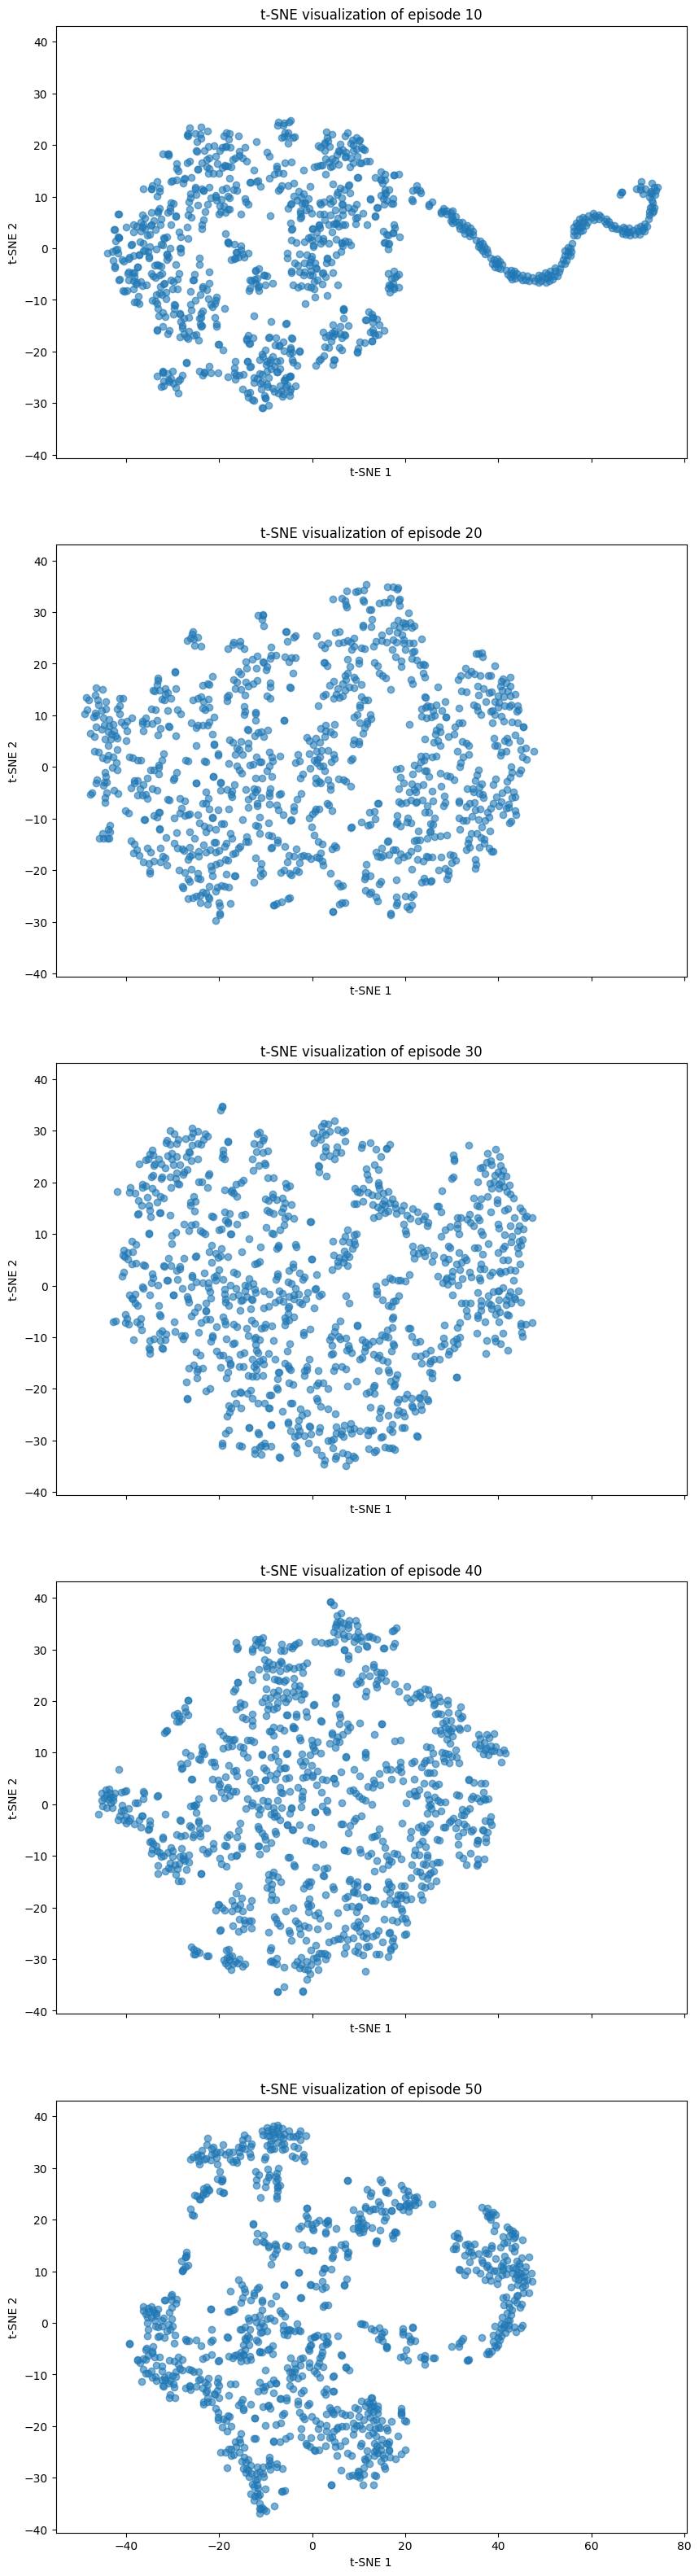

In [14]:
visualize_embeddings_evolution(sa_evolution[:5], "State-Action Embeddings Evolution", "State-Action Embeddings Evolution.png")

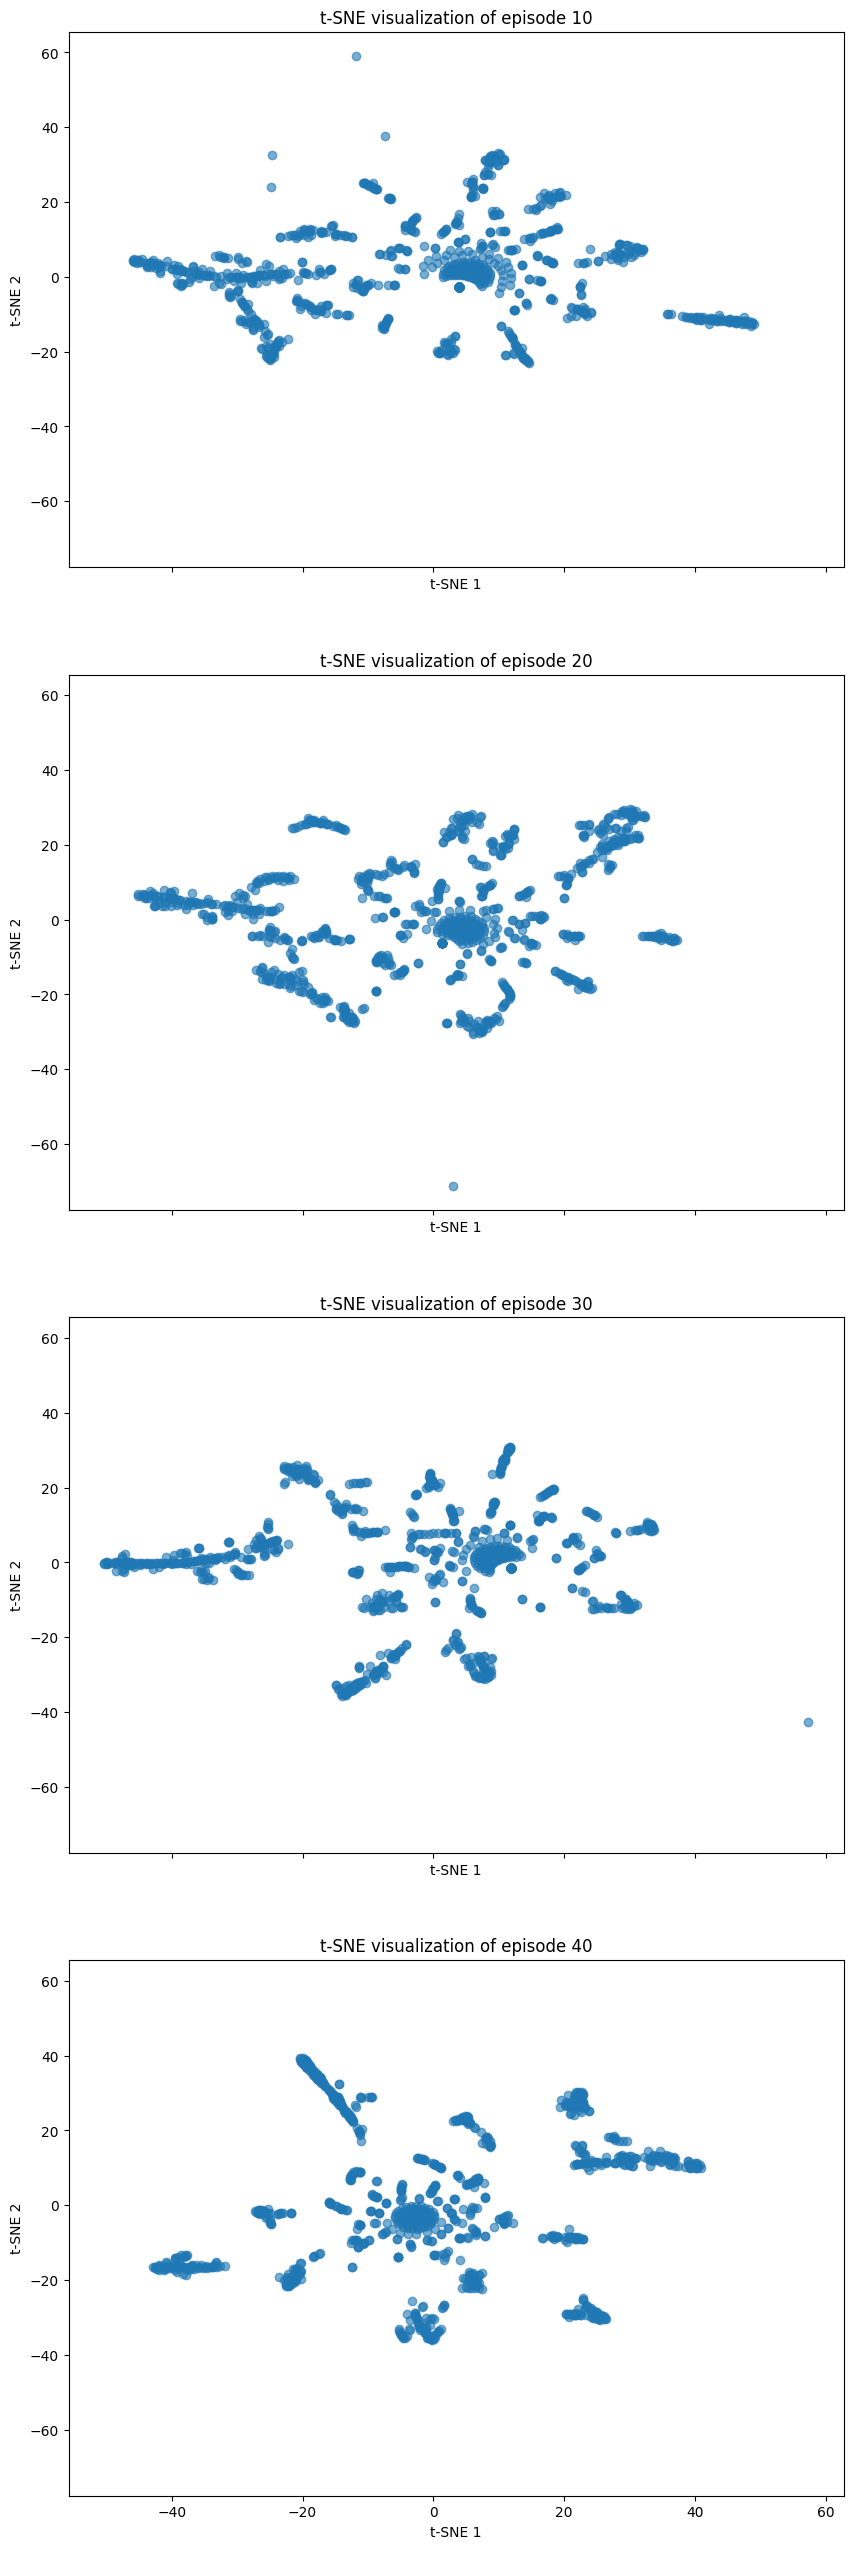

In [10]:
visualize_embeddings_evolution(a_evolution[1:5], "Action Embeddings Evolution", "Action Embeddings Evolution.png")

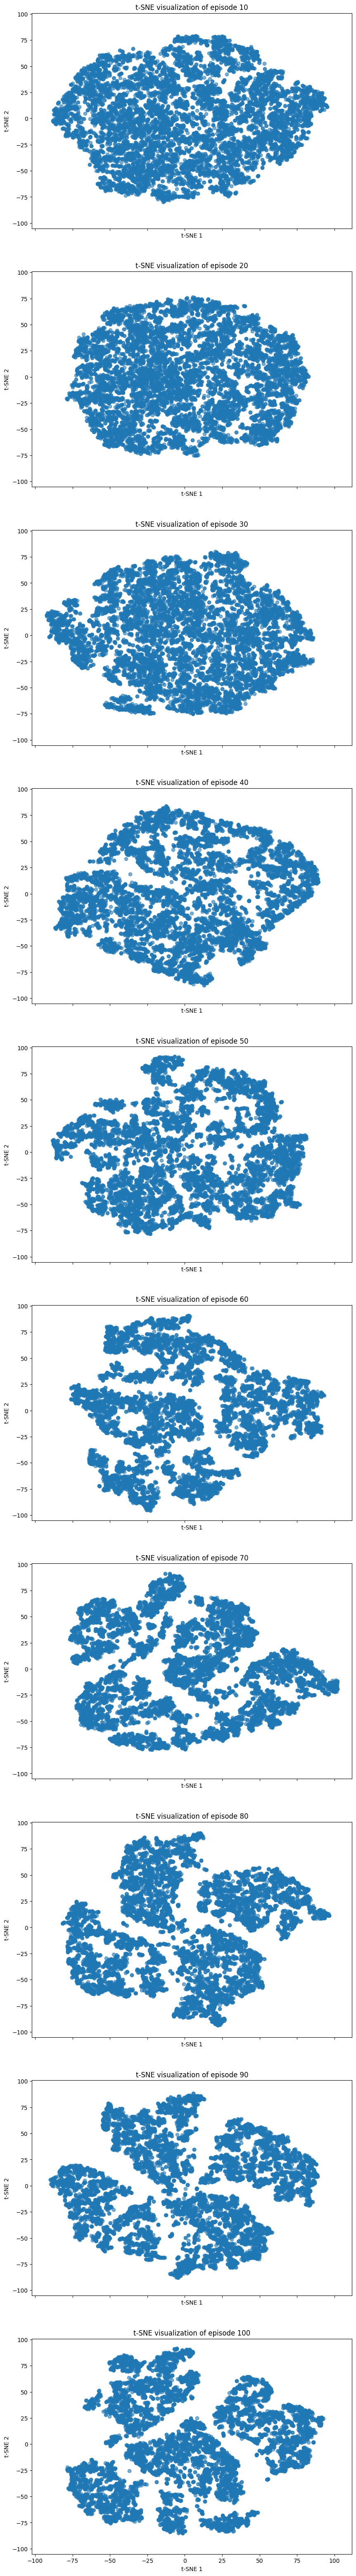

In [12]:
visualize_embeddings_evolution(sa_evolution[1:], 'sa', 'sa_revolution.png', n_samples=1e5)

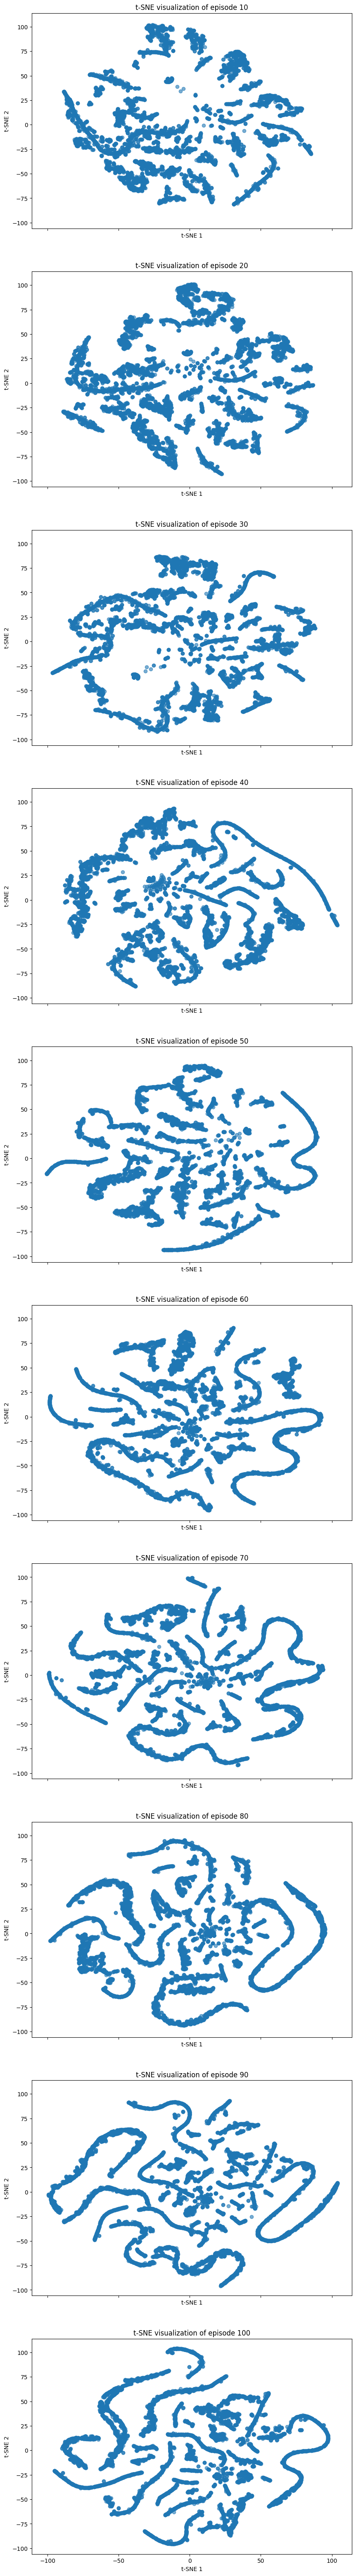

In [13]:
visualize_embeddings_evolution(a_evolution[1:], 'sa', 'sa_revolution.png', n_samples=1e5)